In [1]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

os.environ['PJRT_DEVICE'] = 'TPU' 
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")

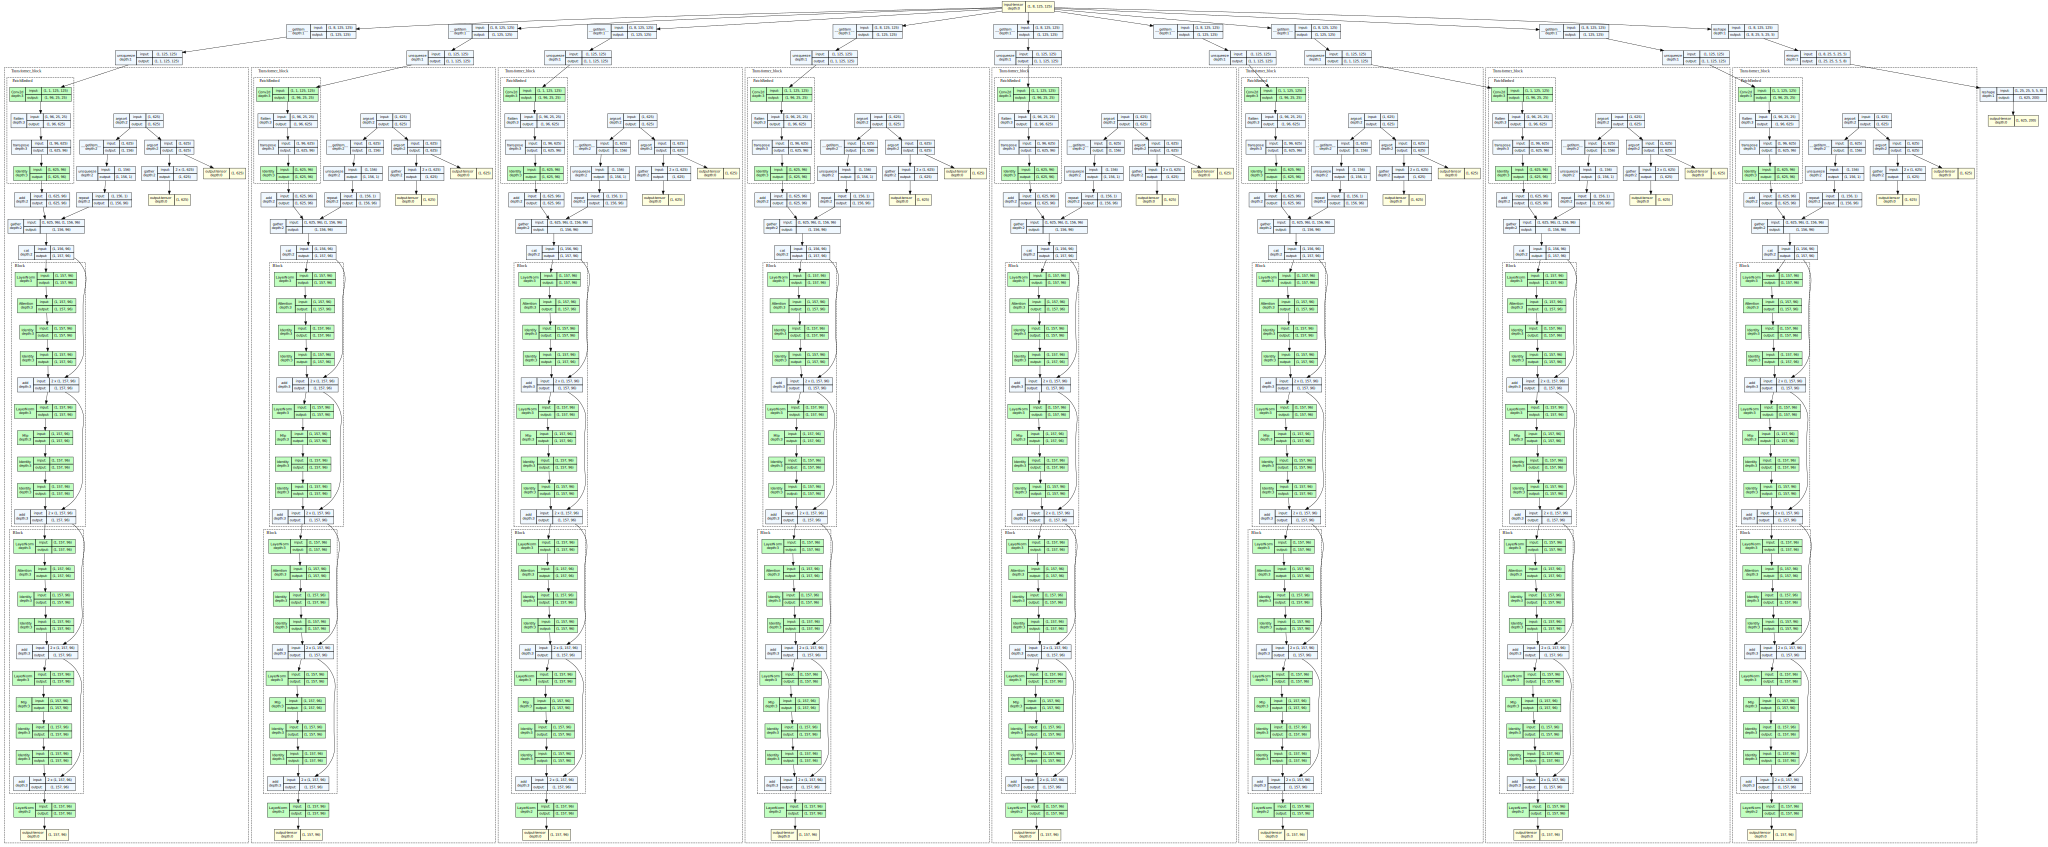

In [2]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
#         imgs = self.patchify(x)

        
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        return x, mask, ids_restore
    
class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.blocks = nn.ModuleList([
            Transformer_block(img_size=img_size, patch_size=patch_size, in_chans=1,
                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)
            for _ in range(8)
        ])
        
    def forward(self, x):
        encoded_tensor = []
        masks = []
        ids = []
        
        for i in range(8):
            img = x[:, i, :, :].unsqueeze(1)
            op, mask, ids_restore = self.blocks[i](img)
            encoded_tensor.append(op)
            masks.append(mask)
            ids.append(ids_restore)
            
        img = self.blocks[0].patchify(x)  # Assuming patchify is the same for all blocks
            
        return encoded_tensor, masks, ids, img

    
import torchvision
from torchview import draw_graph
from torchviz import make_dot
encoder = Encoder(
    img_size=125, patch_size=5, in_chans = 1,embed_dim=96, depth=2, num_heads=8,
    mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [3]:
class Decoder_transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 8, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        # print(decoder_pos_embed.shape)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def forward(self, x):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
#         mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
#         x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         x =   # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
             embed_dim=1024, depth=24, num_heads=16,
             decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
             mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.block = Decoder_transformer_block(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                                                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                                                 decoder_embed_dim=decoder_embed_dim, decoder_depth=decoder_depth, decoder_num_heads=decoder_num_heads,
                                                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)
        
        self.mask_token = nn.Parameter(torch.zeros(1, 1, 96))
        
    def forward(self, x, ids):
        
        op = []
        cls_token = []
        for i in range(len(x)):
#             print(x[i].shape)
            mask_tokens = self.mask_token.repeat(x[i].shape[0], ids[i].shape[1] + 1 - x[i].shape[1], 1)
            x_ = torch.cat([x[i][:, 1:, :], mask_tokens], dim=1)  # no cls token
            cls_token.append(x[i][:,:1,:])
            x_ = torch.gather(x_, dim=1, index=ids[i].unsqueeze(-1).repeat(1, 1, x[i].shape[2]))  # unshuffle
            op.append(x_)
    
        op = torch.cat(op, axis = 2)
        cls_token = torch.cat(cls_token, axis = 2)
#         print(op.shape)
        op = torch.cat([cls_token, op], dim=1)
#         print(op.shape)
        op = self.block(op)
        return op

In [4]:
def get_sinusoid_encoding(num_tokens, token_len):
    """ Make Sinusoid Encoding Table

        Args:
            num_tokens (int): number of tokens
            token_len (int): length of a token
            
        Returns:
            (torch.FloatTensor) sinusoidal position encoding table
    """

    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

class FeatureDecoder(nn.Module):
    def __init__(self, latent_dim=768, depth=24, num_heads=16, 
                 embed_dim=512, mlp_ratio=4., num_patches=150,
                 norm_layer=nn.LayerNorm, output_latent_dim=256,
                 norm_pix_loss=False):
        super().__init__()
        self.num_patches = num_patches
        self.decoder_embed = nn.Linear(latent_dim, embed_dim, bias=True)
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim), requires_grad=False)
        self.decoder_blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for _ in range(depth)])
        self.decoder_norm = norm_layer(embed_dim)
        self.decoder_pred = nn.Linear(embed_dim, output_latent_dim, bias=True)

        self.initialize_weights()

    def initialize_weights(self):
        decoder_pos_embed = get_sinusoid_encoding(self.num_patches, self.decoder_pos_embed.shape[-1])
        self.decoder_pos_embed.data.copy_(decoder_pos_embed)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.decoder_embed(x)
        x = x + self.decoder_pos_embed
        for block in self.decoder_blocks:
            x = block(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        return x


In [5]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Feature_Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False, output_latent_dim = 256):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)
        self.projection = nn.Linear(in_features = embed_dim, out_features = output_latent_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs
        
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):

        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)
        
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = self.projection(x)

        return x

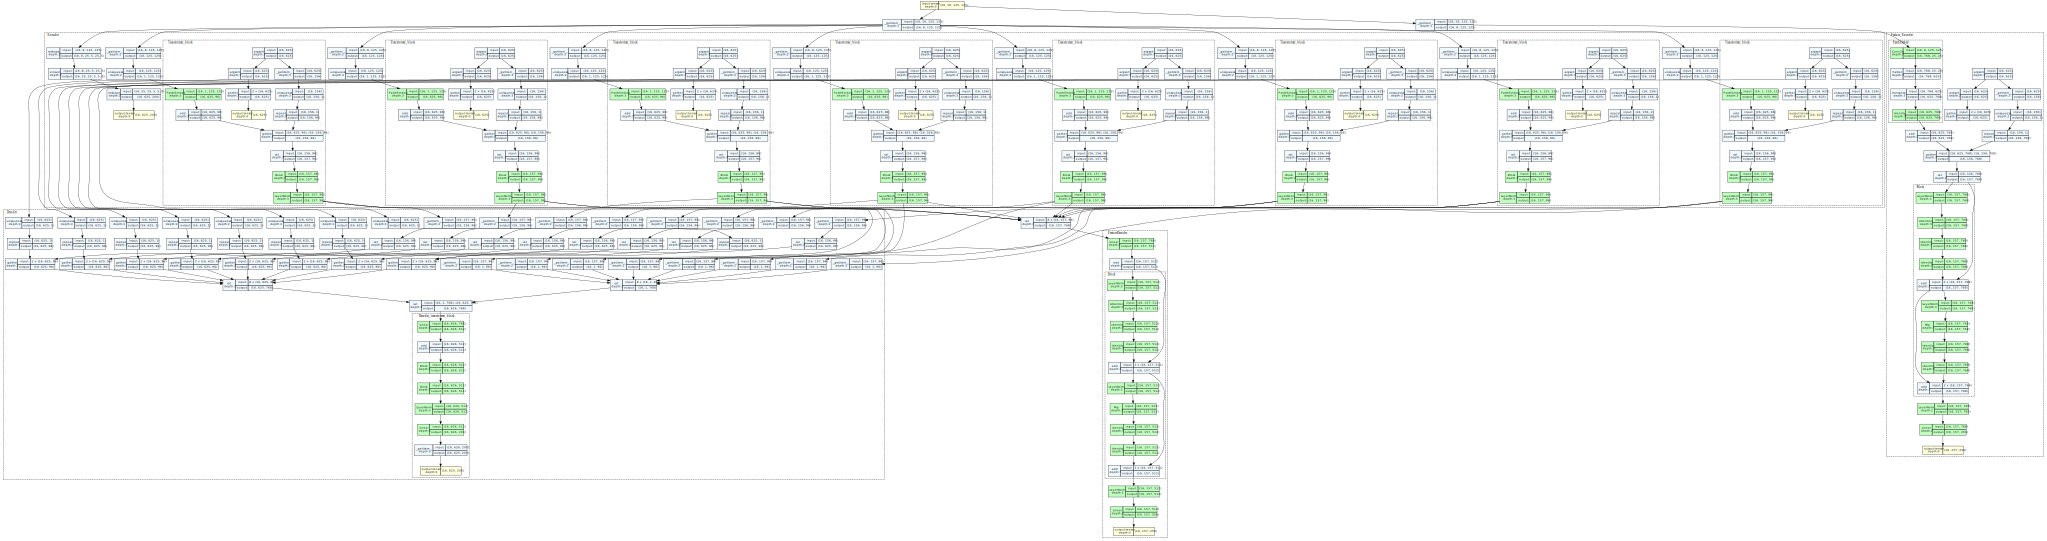

In [6]:
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, feature_decoder, feature_encoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.feature_decoder = feature_decoder
        self.feature_encoder = feature_encoder
        self.mask_ratio = mask_ratio
        
    def forward(self, inp):
        batch_size, channels, height, width = inp.shape
        x = inp[:, :8, :, :]
        y = inp[:, 8:16, :, :]
        # print(x.shape)
        # print(y.shape)
        feature_encoded_output = self.feature_encoder(y)
        
        x, mask, ids_restore, img = self.encoder(x)
        pred = self.decoder(x, ids_restore)
        
        concatenated_latent = torch.cat(x, axis = -1)
        # print(concatenated_latent.shape)
        feature_decoded_output = self.feature_decoder(concatenated_latent)
        # print(feature_decoded_output.shape)
        
        return pred, mask, img, feature_decoded_output, feature_encoded_output
    
def mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75, patch_size = 5, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=5, embed_dim=96, depth=1, num_heads=8,in_chans = 1,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=1, num_heads=8,in_chans = 1,
        decoder_embed_dim=512, decoder_depth=2, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)

    feature_decoder = FeatureDecoder(latent_dim = 768, depth = 1, num_heads = 16, 
                                     embed_dim = 512, output_latent_dim = 256,
                                     num_patches = 157, )
    
    feature_encoder = Feature_Encoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=1, num_heads=12,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, feature_decoder, feature_encoder, mask_ratio)
    
    return model

# Instantiate the model
model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(16,16,125,125), expand_nested=True)
model_graph.visual_graph

In [7]:
from tqdm import tqdm
import gc
from PIL import Image
X_Pretrain = []
for i in tqdm(range(10000)):
    with Image.open(f'/home/shashank/Extracted/0/{i+1}.png') as img:
        img_arr = np.array(img).reshape((125,125,8))
        X_Pretrain.append(img_arr)
        
    with Image.open(f'/home/shashank/Extracted/1/{i+1}.png') as img:
        img_arr = np.array(img).reshape((125,125,8))
        X_Pretrain.append(img_arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 508.89it/s]


In [8]:
length = len(X_Pretrain)
X_train = X_Pretrain[:int(0.8*length)]
X_test = X_Pretrain[int(0.8*length): int(length)]

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# Initialize lists to hold means and stds for each channel
mean = []
std = []

# Calculate mean and std for each channel
for i in range(X_train.shape[-1]):  # Assuming the last dimension is the channel
    mean.append(X_train[:, :, :, i].mean())
    std.append(X_train[:, :, :, i].std())

# Normalize each channel
for i in range(X_train.shape[-1]):
    X_train[:, :, :, i] = (X_train[:, :, :, i] - mean[i]) / std[i]
    X_test[:, :, :, i] = (X_test[:, :, :, i] - mean[i]) / std[i]

# Perform zero suppression
X_train[X_train < 1e-3] = 0

In [10]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, transform1, transform2):
        self.x = x
        self.transform1 = transform1
        self.transform2 = transform2
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = (self.x[idx]).astype('float32')
        img_2 = img_1
        if self.transform1:
            img_1 = self.transform1(img_1)
            
        if self.transform2:
            img_2 = self.transform2(img_2)
            
        sample = {'img1' : img_1, 'img2' : img_2}
        
        return sample

In [11]:
transform1 = transforms.Compose([transforms.ToTensor()])
transform2 = transforms.Compose([transforms.ToTensor(),
                                 transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))])

dataset = Custom_Dataset(X_train, transform1 = transform1, transform2 = transform2)
sample = dataset.__getitem__(0)

print("X_train shape:", X_train.shape)
print("Sample image shape:", sample['img1'].shape)
print("Sample image values:", sample['img2'].shape)

X_train shape: (16000, 125, 125, 8)
Sample image shape: torch.Size([8, 125, 125])
Sample image values: torch.Size([8, 125, 125])


In [12]:
# img = torch.cat((sample['img1'], sample['img2']), axis = 0)
# print(img.shape)
# op= model(img.unsqueeze(0))
# print(op)

In [13]:
# dataloader_train = torch.utils.data.DataLoader(dataset,
#                                                     batch_size=64,
#                                                     # sampler = train_sampler,
#                                                     drop_last = True,
#                                                     num_workers=1,
#                                                     pin_memory = True)
# for step, batch in (enumerate(dataloader_train)):
#     image1 = batch['img1']
#     image2 = batch['img2']
#     img = torch.cat((image1, image2), axis = 1)
#     print(img.shape)
#     break

In [14]:
def reduce_fn(vals):
    # take average
    return sum(vals) / len(vals)

In [15]:
def train_one_epoch(model, train_dataloader, valid_dataloader, criterion, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []

    model.train()
    scheduler.step()

    for step, batch in (enumerate(train_dataloader)):
        image1 = batch['img1'].to(device)
        image2 = batch['img2'].to(device)
        # xm.master_print(f'size -1', image1.shape, image2.shape)
        optimizer.zero_grad()
        img = torch.cat((image1, image2), axis = 1)
        # xm.master_print(f'size -2', img.shape)
        outputs, ind, target, feature_decoded_output, feature_encoded_output = model(img)
        loss = criterion(target, outputs, ind, feature_decoded_output, feature_encoded_output)
        loss.backward()
        xm.optimizer_step(optimizer)
        
        if step%500 == 0:
            xm.master_print(f'Train_Batch: {step}, loss: {loss.item()}')

        loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
        # xm.master_print(f'issue_here')
        train_loss.append(loss_reduced.detach().cpu().numpy())
        # xm.master_print(f'no_issue_here')
        gc.collect()

    model.eval()
    # print('Evaluation')
    with torch.no_grad():
        for step, batch in (enumerate(valid_dataloader)):
            
            image1 = batch['img1'].to(device)
            image2 = batch['img2'].to(device)
            img = torch.cat((image1, image2), axis = 1)
            
            outputs, ind, target, feature_decoded_output, feature_encoded_output = model(img)
            loss = criterion(target, outputs, ind, feature_decoded_output, feature_encoded_output)
            
            loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
            valid_loss.append(loss_reduced.detach().cpu().numpy())
            
            if step%500 == 0:
                xm.master_print(f'Train_Batch: {step}, loss: {loss.item()}')
            gc.collect()

    return np.mean(train_loss), np.mean(valid_loss)

In [16]:
def data():
    ## Train dataset transformations
    train_transform1 = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(60),])
    
    train_transform2 = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(60),
                                transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))])

    ## Test dataset transformations
    test_transform = transforms.Compose([
                                transforms.ToTensor(),])
    test_transform2 = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))])

    ##Train Dataset
    train_dataset = Custom_Dataset(X_train, transform1 = train_transform1, transform2 = train_transform2)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test, transform1 = test_transform, transform2 = test_transform2)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=64,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=64,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [17]:
# import torch
# import numpy as np

# def custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output):
#     # Reconstruction Loss
#     tau = 1.5
#     imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], 8, imgs.shape[2] // 8))
#     pred = pred.reshape((pred.shape[0], pred.shape[1], 8, pred.shape[2] // 8))

#     L = 0
#     for i in range(8):
#         l = ((pred[:, :, i, :] - imgs[:, :, i, :])**2).mean(dim=-1, keepdim=True)
#         mask_cpu = mask[i].unsqueeze(dim=-1)
#         loss = (l * mask_cpu).sum()
#         L += (loss / mask_cpu.sum())

#     # Contrastive Loss
#     L_C = 0
#     num_samples = imgs.shape[0]

#     maxx = feature_encoded_output.max()
#     maxxi = feature_decoded_output.max()
#     feature_encoded_output = (feature_encoded_output.view(num_samples, -1))/(maxx)
#     feature_decoded_output = (feature_decoded_output.view(num_samples, -1))/(maxxi)
    
    
#     dot_products = torch.matmul(feature_encoded_output, feature_decoded_output.T) / tau
#     exp_dot_products = torch.exp(dot_products)
#     # print(dot_products)
#     print(torch.exp(dot_products.max()))
#     for i in range(num_samples):
#         numerator = exp_dot_products[i, i]
#         denominator = exp_dot_products[i, :].sum()
#         L_C += -torch.log(numerator / denominator)

#     L_C /= num_samples
    
#     return L / 8 + L_C * 0.5

# # Example usage
# imgs = torch.randn(16, 625, 200)
# pred = torch.randn(16, 625, 200)
# mask = torch.randint(0, 2, (16, 625))
# feature_decoded_output = torch.rand((16, 157, 768))
# feature_encoded_output = torch.rand((16, 157, 768))
# tau = 0.5

# loss = custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output)
# print(loss)
import torch
import numpy as np

def custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output):
    # Reconstruction Loss
    tau = 1.5
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], 8, imgs.shape[2] // 8))
    pred = pred.reshape((pred.shape[0], pred.shape[1], 8, pred.shape[2] // 8))

    L = 0
    for i in range(8):
        l = ((pred[:, :, i, :] - imgs[:, :, i, :])**2).mean(dim=-1, keepdim=True)
        mask_cpu = mask[i].unsqueeze(dim=-1)
        loss = (l * mask_cpu).sum()
        L += (loss / mask_cpu.sum())

    # Contrastive Loss
    L_C = 0
    num_samples = imgs.shape[0]

    feature_encoded_output = feature_encoded_output.view(num_samples, -1)
    feature_decoded_output = feature_decoded_output.view(num_samples, -1)
    
    # Normalize the feature vectors
    feature_encoded_output = feature_encoded_output / feature_encoded_output.norm(dim=1, keepdim=True)
    feature_decoded_output = feature_decoded_output / feature_decoded_output.norm(dim=1, keepdim=True)
    
    dot_products = torch.matmul(feature_encoded_output, feature_decoded_output.T) / tau
    
    # Log-Sum-Exp trick to avoid numerical instability
    max_dot_products = torch.max(dot_products, dim=1, keepdim=True)[0]
    exp_dot_products = torch.exp(dot_products - max_dot_products)
    
    for i in range(num_samples):
        numerator = exp_dot_products[i, i]
        denominator = exp_dot_products[i, :].sum()
        L_C += -torch.log(numerator / denominator)

    L_C /= num_samples
    
    return L / 8 + L_C * 0.5

# Example usage
imgs = torch.randn(16, 625, 200)
pred = torch.randn(16, 625, 200)
mask = torch.randint(0, 2, (16, 625))
feature_decoded_output = torch.rand((16, 157, 768))
feature_encoded_output = torch.rand((16, 157, 768))
tau = 0.5

loss = custom_loss(imgs, pred, mask, feature_decoded_output, feature_encoded_output)
print(loss)


tensor(33.3832)


In [18]:

def train_function(model, epochs):
    criterion = custom_loss
    lr = 0.001
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = xm.xla_device()
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in tqdm(range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss = train_one_epoch(model, train_loader, valid_loader, criterion, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./Model_files/xla_trained_model_epoch.pth')

def _mp_fn(rank, flags):
    try:
        model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio=0.75)
        dev = xm.xla_device()
        model = model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(model, epochs=80)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

I0000 00:00:1718253285.992429  281251 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718253285.992420  281250 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718253285.992641  281251 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1718253285.992644  281250 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1718253285.992654  281251 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API version is 0.46.
I0000 00:00:1718253285.992664  281250 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API version is 0.46.
I0000 00:00:1718253285.995775  281252 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718253285.995890  281252 pjrt_api.cc:79] PJRT_Api is set for devic

num_training_steps = 2500, world_size=8


  0%|                                                                                                                               | 0/80 [00:00<?, ?it/s]

Train_Batch: 0, loss: 4.408493995666504
Train_Batch: 0, loss: 2.987959384918213


  1%|█▍                                                                                                                  | 1/80 [04:17<5:39:31, 257.86s/it]

Epoch 1/80, Train Loss: 3.5644, Val Loss: 3.0458

  1%|█▍                                                                                                                  | 1/80 [04:19<5:41:01, 259.01s/it]

Train_Batch: 0, loss: 3.0056896209716797
Train_Batch: 0, loss: 2.9572412967681885


  2%|██▉                                                                                                                 | 2/80 [05:50<3:29:09, 160.89s/it]


Epoch 2/80, Train Loss: 2.9654, Val Loss: 3.0197

  2%|██▉                                                                                                                 | 2/80 [05:52<3:29:42, 161.31s/it]

  2%|██▉                                                                                                                 | 2/80 [05:53<3:30:10, 161.67s/it]

Train_Batch: 0, loss: 2.998826026916504
Train_Batch: 0, loss: 2.9722070693969727


  4%|████▎                                                                                                               | 3/80 [07:22<2:45:47, 129.19s/it]

Epoch 3/80, Train Loss: 2.9571, Val Loss: 3.0219


  4%|████▎                                                                                                               | 3/80 [07:24<2:46:13, 129.53s/it]

Train_Batch: 0, loss: 3.005997657775879
Train_Batch: 0, loss: 2.9557032585144043



  5%|█████▊                                                                                                              | 4/80 [08:53<2:24:55, 114.41s/it]

Epoch 4/80, Train Loss: 2.9574, Val Loss: 3.0216

  5%|█████▊                                                                                                              | 4/80 [08:55<2:25:11, 114.62s/it]


  5%|█████▊                                                                                                              | 4/80 [08:56<2:25:18, 114.72s/it]

Train_Batch: 0, loss: 2.970053195953369
Train_Batch: 0, loss: 2.965257406234741



  6%|███████▎                                                                                                            | 5/80 [10:27<2:13:25, 106.74s/it]


Epoch 5/80, Train Loss: 2.9574, Val Loss: 3.0213

  6%|███████▎                                                                                                            | 5/80 [10:28<2:13:36, 106.89s/it]


  6%|███████▎                                                                                                            | 5/80 [10:29<2:13:36, 106.89s/it]

Train_Batch: 0, loss: 2.963589668273926
Train_Batch: 0, loss: 2.9447498321533203


  8%|████████▋                                                                                                           | 6/80 [11:59<2:05:33, 101.80s/it]

Epoch 6/80, Train Loss: 2.9579, Val Loss: 3.0211

  8%|████████▋                                                                                                           | 6/80 [12:00<2:05:36, 101.85s/it]


  8%|████████▋                                                                                                           | 6/80 [12:02<2:05:49, 102.02s/it]

Train_Batch: 0, loss: 2.986386775970459
Train_Batch: 0, loss: 2.957184314727783


  9%|██████████▏                                                                                                          | 7/80 [13:31<1:59:59, 98.62s/it]

Epoch 7/80, Train Loss: 2.9550, Val Loss: 3.0221



  9%|██████████▏                                                                                                          | 7/80 [13:34<2:00:09, 98.76s/it]

Train_Batch: 0, loss: 2.9544801712036133
Train_Batch: 0, loss: 2.9562435150146484


 10%|███████████▋                                                                                                         | 8/80 [15:05<1:56:28, 97.07s/it]

Epoch 8/80, Train Loss: 2.9552, Val Loss: 3.0213


 10%|███████████▋                                                                                                         | 8/80 [15:05<1:56:25, 97.02s/it]


 10%|███████████▋                                                                                                         | 8/80 [15:08<1:56:36, 97.17s/it]

Train_Batch: 0, loss: 2.958925247192383
Train_Batch: 0, loss: 2.980497360229492


 11%|█████████████▏                                                                                                       | 9/80 [16:37<1:52:47, 95.32s/it]

Epoch 9/80, Train Loss: 2.9564, Val Loss: 3.0236


 11%|█████████████▏                                                                                                       | 9/80 [16:39<1:52:54, 95.42s/it]

Train_Batch: 0, loss: 2.9598803520202637
Train_Batch: 0, loss: 2.972954034805298


Epoch 10/80, Train Loss: 2.9557, Val Loss: 3.0241

 12%|██████████████▌                                                                                                     | 10/80 [18:11<1:50:49, 94.99s/it]

 12%|██████████████▌                                                                                                     | 10/80 [18:13<1:50:56, 95.09s/it]

Train_Batch: 0, loss: 2.966609001159668
Train_Batch: 0, loss: 2.967775344848633


Epoch 11/80, Train Loss: 2.9564, Val Loss: 3.0234

 14%|███████████████▉                                                                                                    | 11/80 [19:43<1:48:14, 94.12s/it]

 14%|███████████████▉                                                                                                    | 11/80 [19:45<1:48:21, 94.22s/it]

Train_Batch: 0, loss: 2.9856629371643066
Train_Batch: 0, loss: 2.9560184478759766


Epoch 12/80, Train Loss: 2.9555, Val Loss: 3.0250

 15%|█████████████████▍                                                                                                  | 12/80 [21:14<1:45:31, 93.11s/it]


 15%|█████████████████▍                                                                                                  | 12/80 [21:16<1:45:36, 93.19s/it]

Train_Batch: 0, loss: 2.9508256912231445
Train_Batch: 0, loss: 2.9487006664276123


Epoch 13/80, Train Loss: 2.9587, Val Loss: 3.0188


 16%|██████████████████▊                                                                                                 | 13/80 [22:46<1:43:07, 92.35s/it]

Train_Batch: 0, loss: 2.9944941997528076
Train_Batch: 0, loss: 2.9496471881866455



 18%|████████████████████▎                                                                                               | 14/80 [24:16<1:41:34, 92.33s/it]


Epoch 14/80, Train Loss: 2.9565, Val Loss: 3.0199

 18%|████████████████████▎                                                                                               | 14/80 [24:18<1:41:29, 92.27s/it]


 18%|████████████████████▎                                                                                               | 14/80 [24:19<1:41:39, 92.42s/it]

Train_Batch: 0, loss: 2.9421980381011963
Train_Batch: 0, loss: 2.9425477981567383


Epoch 15/80, Train Loss: 2.9557, Val Loss: 3.0196


 19%|█████████████████████▊                                                                                              | 15/80 [25:52<1:40:07, 92.43s/it]

Train_Batch: 0, loss: 2.9496212005615234
Train_Batch: 0, loss: 2.9637820720672607



 20%|███████████████████████▏                                                                                            | 16/80 [27:21<1:38:40, 92.51s/it]

Epoch 16/80, Train Loss: 2.9557, Val Loss: 3.0223


 20%|███████████████████████▏                                                                                            | 16/80 [27:25<1:38:44, 92.57s/it]

Train_Batch: 0, loss: 2.961658000946045
Train_Batch: 0, loss: 2.9787662029266357


 21%|████████████████████████▋                                                                                           | 17/80 [28:53<1:36:34, 91.98s/it]

Epoch 17/80, Train Loss: 2.9565, Val Loss: 3.0202



 21%|████████████████████████▋                                                                                           | 17/80 [28:56<1:36:44, 92.14s/it]

Train_Batch: 0, loss: 2.9874839782714844
Train_Batch: 0, loss: 2.954817295074463



 22%|██████████████████████████                                                                                          | 18/80 [30:26<1:35:41, 92.61s/it]

Epoch 18/80, Train Loss: 2.9569, Val Loss: 3.0214

 22%|██████████████████████████                                                                                          | 18/80 [30:29<1:35:46, 92.68s/it]

Train_Batch: 0, loss: 2.97955322265625
Train_Batch: 0, loss: 2.9720282554626465



 24%|███████████████████████████▌                                                                                        | 19/80 [31:57<1:33:29, 91.96s/it]

Epoch 19/80, Train Loss: 2.9558, Val Loss: 3.0223


 24%|███████████████████████████▌                                                                                        | 19/80 [32:00<1:33:31, 91.99s/it]

Train_Batch: 0, loss: 2.996755361557007
Train_Batch: 0, loss: 2.9640390872955322


 25%|█████████████████████████████                                                                                       | 20/80 [33:31<1:32:19, 92.32s/it]

Epoch 20/80, Train Loss: 2.9573, Val Loss: 3.0216

 25%|█████████████████████████████                                                                                       | 20/80 [33:33<1:32:26, 92.44s/it]

Train_Batch: 0, loss: 2.9683823585510254
Train_Batch: 0, loss: 2.9562478065490723
Epoch 21/80, Train Loss: 2.9533, Val Loss: 3.0207

 26%|██████████████████████████████▍                                                                                     | 21/80 [35:03<1:30:43, 92.27s/it]


 26%|██████████████████████████████▍                                                                                     | 21/80 [35:05<1:30:48, 92.35s/it]

Train_Batch: 0, loss: 2.976722240447998
Train_Batch: 0, loss: 2.975574254989624


 28%|███████████████████████████████▉                                                                                    | 22/80 [36:38<1:29:50, 92.94s/it]

Epoch 22/80, Train Loss: 2.9564, Val Loss: 3.0257

 28%|███████████████████████████████▉                                                                                    | 22/80 [36:38<1:29:50, 92.94s/it]


 28%|███████████████████████████████▉                                                                                    | 22/80 [36:40<1:29:53, 93.00s/it]

Train_Batch: 0, loss: 2.978341579437256
Train_Batch: 0, loss: 2.9538822174072266



 29%|█████████████████████████████████▎                                                                                  | 23/80 [38:12<1:28:36, 93.27s/it]


Epoch 23/80, Train Loss: 2.9582, Val Loss: 3.0185


 29%|█████████████████████████████████▎                                                                                  | 23/80 [38:13<1:28:40, 93.34s/it]

Train_Batch: 0, loss: 2.966114044189453
Train_Batch: 0, loss: 2.9758760929107666



 30%|██████████████████████████████████▊                                                                                 | 24/80 [39:44<1:26:35, 92.79s/it]

Epoch 24/80, Train Loss: 2.9559, Val Loss: 3.0211

 30%|██████████████████████████████████▊                                                                                 | 24/80 [39:46<1:26:41, 92.88s/it]

Train_Batch: 0, loss: 2.98974347114563
Train_Batch: 0, loss: 2.949787139892578
Epoch 25/80, Train Loss: 2.9564, Val Loss: 3.0215

 31%|████████████████████████████████████▎                                                                               | 25/80 [41:15<1:24:42, 92.41s/it]

 31%|████████████████████████████████████▎                                                                               | 25/80 [41:17<1:24:47, 92.49s/it]

Train_Batch: 0, loss: 2.968536615371704
Train_Batch: 0, loss: 2.9540677070617676


 32%|█████████████████████████████████████▋                                                                              | 26/80 [42:48<1:23:22, 92.65s/it]

Epoch 26/80, Train Loss: 2.9515, Val Loss: 3.0215

 32%|█████████████████████████████████████▋                                                                              | 26/80 [42:49<1:23:28, 92.74s/it]

Train_Batch: 0, loss: 2.9460182189941406
Train_Batch: 0, loss: 2.9534013271331787


 34%|███████████████████████████████████████▏                                                                            | 27/80 [44:22<1:22:06, 92.96s/it]


Epoch 27/80, Train Loss: 2.9468, Val Loss: 2.9926

 34%|███████████████████████████████████████▏                                                                            | 27/80 [44:23<1:22:04, 92.92s/it]


 34%|███████████████████████████████████████▏                                                                            | 27/80 [44:25<1:22:09, 93.00s/it]

Train_Batch: 0, loss: 2.95847225189209
Train_Batch: 0, loss: 2.910332679748535



 35%|████████████████████████████████████████▌                                                                           | 28/80 [45:53<1:20:18, 92.67s/it]

Epoch 28/80, Train Loss: 2.9284, Val Loss: 2.9828



 35%|████████████████████████████████████████▌                                                                           | 28/80 [45:56<1:20:24, 92.77s/it]

Train_Batch: 0, loss: 2.9530694484710693
Train_Batch: 0, loss: 2.932384729385376
Epoch 29/80, Train Loss: 2.9192, Val Loss: 2.9808


 36%|██████████████████████████████████████████                                                                          | 29/80 [47:27<1:18:54, 92.83s/it]

 36%|██████████████████████████████████████████                                                                          | 29/80 [47:29<1:19:01, 92.96s/it]

Train_Batch: 0, loss: 2.918314218521118
Train_Batch: 0, loss: 2.9233922958374023


 38%|███████████████████████████████████████████▌                                                                        | 30/80 [49:00<1:17:05, 92.52s/it]


Epoch 30/80, Train Loss: 2.9205, Val Loss: 2.9751

 38%|███████████████████████████████████████████▌                                                                        | 30/80 [49:00<1:17:09, 92.58s/it]


 38%|███████████████████████████████████████████▌                                                                        | 30/80 [49:02<1:17:11, 92.63s/it]

Train_Batch: 0, loss: 2.937466621398926
Train_Batch: 0, loss: 2.88035249710083


 39%|████████████████████████████████████████████▉                                                                       | 31/80 [50:32<1:15:41, 92.69s/it]


Epoch 31/80, Train Loss: 2.9141, Val Loss: 2.9622

 39%|████████████████████████████████████████████▉                                                                       | 31/80 [50:33<1:15:43, 92.73s/it]


 39%|████████████████████████████████████████████▉                                                                       | 31/80 [50:33<1:15:52, 92.92s/it]

Train_Batch: 0, loss: 2.8881804943084717
Train_Batch: 0, loss: 2.887216091156006



 40%|██████████████████████████████████████████████▍                                                                     | 32/80 [52:05<1:14:06, 92.63s/it]


Epoch 32/80, Train Loss: 2.9043, Val Loss: 2.9527

 40%|██████████████████████████████████████████████▍                                                                     | 32/80 [52:06<1:14:07, 92.66s/it]

 40%|██████████████████████████████████████████████▍                                                                     | 32/80 [52:08<1:14:09, 92.69s/it]

Train_Batch: 0, loss: 2.924225091934204
Train_Batch: 0, loss: 2.9452154636383057


 41%|███████████████████████████████████████████████▊                                                                    | 33/80 [53:39<1:12:54, 93.08s/it]

Epoch 33/80, Train Loss: 2.9108, Val Loss: 2.9994



 41%|███████████████████████████████████████████████▊                                                                    | 33/80 [53:42<1:12:56, 93.13s/it]

Train_Batch: 0, loss: 2.9378609657287598
Train_Batch: 0, loss: 2.912139415740967


 42%|█████████████████████████████████████████████████▎                                                                  | 34/80 [55:14<1:11:41, 93.52s/it]

Epoch 34/80, Train Loss: 2.9382, Val Loss: 2.9851



 42%|█████████████████████████████████████████████████▎                                                                  | 34/80 [55:15<1:11:47, 93.64s/it]

Train_Batch: 0, loss: 2.9433302879333496
Train_Batch: 0, loss: 2.8997623920440674


 44%|██████████████████████████████████████████████████▊                                                                 | 35/80 [56:48<1:10:06, 93.49s/it]


Epoch 35/80, Train Loss: 2.9482, Val Loss: 2.9811

 44%|██████████████████████████████████████████████████▊                                                                 | 35/80 [56:48<1:10:09, 93.54s/it]


 44%|██████████████████████████████████████████████████▊                                                                 | 35/80 [56:50<1:10:10, 93.56s/it]

Train_Batch: 0, loss: 2.94706392288208
Train_Batch: 0, loss: 2.907334327697754


 45%|████████████████████████████████████████████████████▏                                                               | 36/80 [58:22<1:08:40, 93.65s/it]

Epoch 36/80, Train Loss: 2.9124, Val Loss: 2.9644



 45%|████████████████████████████████████████████████████▏                                                               | 36/80 [58:23<1:08:47, 93.80s/it]

Train_Batch: 0, loss: 2.90983510017395
Train_Batch: 0, loss: 2.8946287631988525


Epoch 37/80, Train Loss: 2.9078, Val Loss: 2.9596


 46%|█████████████████████████████████████████████████████▋                                                              | 37/80 [59:56<1:06:52, 93.32s/it]

Train_Batch: 0, loss: 2.917196273803711
Train_Batch: 0, loss: 2.883127450942993


 48%|██████████████████████████████████████████████████████▏                                                           | 38/80 [1:01:29<1:05:42, 93.87s/it]

Epoch 38/80, Train Loss: 2.9032, Val Loss: 2.9647


 48%|██████████████████████████████████████████████████████▏                                                           | 38/80 [1:01:31<1:05:47, 93.99s/it]

Train_Batch: 0, loss: 2.9251084327697754
Train_Batch: 0, loss: 2.8874237537384033


Epoch 39/80, Train Loss: 2.8997, Val Loss: 2.9530


 49%|███████████████████████████████████████████████████████▌                                                          | 39/80 [1:03:05<1:04:13, 93.98s/it]

Train_Batch: 0, loss: 2.916109085083008
Train_Batch: 0, loss: 2.88258957862854


 50%|█████████████████████████████████████████████████████████                                                         | 40/80 [1:04:36<1:02:30, 93.76s/it]

Epoch 40/80, Train Loss: 2.8970, Val Loss: 2.9478


 50%|█████████████████████████████████████████████████████████                                                         | 40/80 [1:04:38<1:02:34, 93.86s/it]

Train_Batch: 0, loss: 2.9391462802886963
Train_Batch: 0, loss: 2.881265640258789


 51%|██████████████████████████████████████████████████████████▍                                                       | 41/80 [1:06:09<1:00:41, 93.36s/it]

Epoch 41/80, Train Loss: 2.8950, Val Loss: 2.9476


 51%|██████████████████████████████████████████████████████████▍                                                       | 41/80 [1:06:11<1:00:42, 93.40s/it]

Train_Batch: 0, loss: 2.902522087097168
Train_Batch: 0, loss: 2.8914036750793457


 52%|████████████████████████████████████████████████████████████▉                                                       | 42/80 [1:07:43<59:20, 93.69s/it]

Epoch 42/80, Train Loss: 2.8943, Val Loss: 2.9507



 52%|████████████████████████████████████████████████████████████▉                                                       | 42/80 [1:07:46<59:24, 93.81s/it]

Train_Batch: 0, loss: 2.9223475456237793
Train_Batch: 0, loss: 2.883756637573242


 54%|██████████████████████████████████████████████████████████████▎                                                     | 43/80 [1:09:17<57:49, 93.77s/it]

Epoch 43/80, Train Loss: 2.8943, Val Loss: 2.9501



 54%|██████████████████████████████████████████████████████████████▎                                                     | 43/80 [1:09:19<57:53, 93.88s/it]

Train_Batch: 0, loss: 2.903632640838623
Train_Batch: 0, loss: 2.8791816234588623



 55%|███████████████████████████████████████████████████████████████▊                                                    | 44/80 [1:10:51<56:06, 93.51s/it]

Epoch 44/80, Train Loss: 2.8913, Val Loss: 2.9481


 55%|███████████████████████████████████████████████████████████████▊                                                    | 44/80 [1:10:53<56:07, 93.55s/it]

Train_Batch: 0, loss: 2.8941755294799805
Train_Batch: 0, loss: 2.8727664947509766


Epoch 45/80, Train Loss: 2.8867, Val Loss: 2.9433

 56%|█████████████████████████████████████████████████████████████████▎                                                  | 45/80 [1:12:24<54:28, 93.37s/it]


 56%|█████████████████████████████████████████████████████████████████▎                                                  | 45/80 [1:12:26<54:30, 93.45s/it]

Train_Batch: 0, loss: 2.893357038497925
Train_Batch: 0, loss: 2.8600358963012695



 57%|██████████████████████████████████████████████████████████████████▋                                                 | 46/80 [1:13:58<53:01, 93.56s/it]

Epoch 46/80, Train Loss: 2.8864, Val Loss: 2.9393


 57%|██████████████████████████████████████████████████████████████████▋                                                 | 46/80 [1:14:00<53:05, 93.70s/it]

Train_Batch: 0, loss: 2.885645627975464
Train_Batch: 0, loss: 2.873290538787842



 59%|████████████████████████████████████████████████████████████████████▏                                               | 47/80 [1:15:31<51:33, 93.74s/it]


Epoch 47/80, Train Loss: 2.8825, Val Loss: 2.9396

 59%|████████████████████████████████████████████████████████████████████▏                                               | 47/80 [1:15:33<51:32, 93.71s/it]


 59%|████████████████████████████████████████████████████████████████████▏                                               | 47/80 [1:15:34<51:35, 93.80s/it]

Train_Batch: 0, loss: 2.901491165161133
Train_Batch: 0, loss: 2.8656532764434814
Epoch 48/80, Train Loss: 2.8856, Val Loss: 2.9378

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 48/80 [1:17:06<49:55, 93.60s/it]

Train_Batch: 0, loss: 2.8984246253967285
Train_Batch: 0, loss: 2.869889974594116


 61%|███████████████████████████████████████████████████████████████████████                                             | 49/80 [1:18:38<48:21, 93.59s/it]


Epoch 49/80, Train Loss: 2.8826, Val Loss: 2.9422


 61%|███████████████████████████████████████████████████████████████████████                                             | 49/80 [1:18:41<48:23, 93.66s/it]

Train_Batch: 0, loss: 2.9034838676452637
Train_Batch: 0, loss: 2.8713624477386475


 62%|████████████████████████████████████████████████████████████████████████▌                                           | 50/80 [1:20:10<46:26, 92.90s/it]

Epoch 50/80, Train Loss: 2.8890, Val Loss: 2.9409

 62%|████████████████████████████████████████████████████████████████████████▌                                           | 50/80 [1:20:10<46:28, 92.93s/it]

 62%|████████████████████████████████████████████████████████████████████████▌                                           | 50/80 [1:20:11<46:31, 93.06s/it]

Train_Batch: 0, loss: 2.9116122722625732
Train_Batch: 0, loss: 2.8719000816345215


 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 51/80 [1:21:42<44:56, 92.97s/it]

Epoch 51/80, Train Loss: 2.8853, Val Loss: 2.9380



 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 51/80 [1:21:45<44:58, 93.06s/it]

Train_Batch: 0, loss: 2.9001193046569824
Train_Batch: 0, loss: 2.8671364784240723



 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 52/80 [1:23:16<43:13, 92.62s/it]


Epoch 52/80, Train Loss: 2.8848, Val Loss: 2.9400

 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 52/80 [1:23:16<43:14, 92.67s/it]


 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 52/80 [1:23:17<43:16, 92.72s/it]

Train_Batch: 0, loss: 2.895376443862915
Train_Batch: 0, loss: 2.867060661315918


 66%|████████████████████████████████████████████████████████████████████████████▊                                       | 53/80 [1:24:48<41:43, 92.72s/it]

Epoch 53/80, Train Loss: 2.8840, Val Loss: 2.9364


 66%|████████████████████████████████████████████████████████████████████████████▊                                       | 53/80 [1:24:50<41:45, 92.81s/it]

Train_Batch: 0, loss: 2.9125778675079346
Train_Batch: 0, loss: 2.8845481872558594


Epoch 54/80, Train Loss: 2.8815, Val Loss: 2.9399


 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 54/80 [1:26:23<40:17, 92.96s/it]

Train_Batch: 0, loss: 2.8795149326324463
Train_Batch: 0, loss: 2.863048791885376


Epoch 55/80, Train Loss: 2.8826, Val Loss: 2.9376


 69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 55/80 [1:27:57<38:44, 92.99s/it]

Train_Batch: 0, loss: 2.9057416915893555
Train_Batch: 0, loss: 2.867107629776001


 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 56/80 [1:29:27<37:12, 93.04s/it]


Epoch 56/80, Train Loss: 2.8821, Val Loss: 2.9387

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 56/80 [1:29:29<37:11, 93.00s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 56/80 [1:29:29<37:14, 93.12s/it]

Train_Batch: 0, loss: 2.90773344039917
Train_Batch: 0, loss: 2.8777949810028076


Epoch 57/80, Train Loss: 2.8821, Val Loss: 2.9381

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 57/80 [1:31:01<35:38, 92.96s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 57/80 [1:31:03<35:37, 92.95s/it]

Train_Batch: 0, loss: 2.905632257461548
Train_Batch: 0, loss: 2.890969753265381


 72%|████████████████████████████████████████████████████████████████████████████████████                                | 58/80 [1:32:33<34:03, 92.89s/it]

Epoch 58/80, Train Loss: 2.8938, Val Loss: 2.9459


 72%|████████████████████████████████████████████████████████████████████████████████████                                | 58/80 [1:32:34<34:04, 92.91s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████                                | 58/80 [1:32:35<34:04, 92.92s/it]

Train_Batch: 0, loss: 2.912358283996582
Train_Batch: 0, loss: 2.859677791595459



 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 59/80 [1:34:08<32:35, 93.14s/it]

Epoch 59/80, Train Loss: 2.8846, Val Loss: 2.9369


 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 59/80 [1:34:09<32:41, 93.39s/it]

Train_Batch: 0, loss: 2.904723644256592
Train_Batch: 0, loss: 2.8648428916931152



 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 60/80 [1:35:38<30:53, 92.67s/it]


Epoch 60/80, Train Loss: 2.8795, Val Loss: 2.9379

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 60/80 [1:35:39<30:53, 92.66s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 60/80 [1:35:41<30:53, 92.69s/it]

Train_Batch: 0, loss: 2.889016628265381
Train_Batch: 0, loss: 2.877983808517456


 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 61/80 [1:37:12<29:29, 93.12s/it]

Epoch 61/80, Train Loss: 2.8812, Val Loss: 2.9348


 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 61/80 [1:37:14<29:37, 93.56s/it]

Train_Batch: 0, loss: 2.9065122604370117
Train_Batch: 0, loss: 2.8891525268554688


 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 62/80 [1:38:48<28:01, 93.39s/it]


Epoch 62/80, Train Loss: 2.8802, Val Loss: 2.9372

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 62/80 [1:38:48<28:00, 93.36s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 62/80 [1:38:49<28:01, 93.41s/it]

Train_Batch: 0, loss: 2.8902881145477295
Train_Batch: 0, loss: 2.853593349456787



 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 63/80 [1:40:19<26:24, 93.21s/it]


Epoch 63/80, Train Loss: 2.8788, Val Loss: 2.9356


 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 63/80 [1:40:22<26:26, 93.30s/it]

Train_Batch: 0, loss: 2.899411201477051
Train_Batch: 0, loss: 2.8841633796691895


 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64/80 [1:41:52<24:48, 93.06s/it]


Epoch 64/80, Train Loss: 2.8777, Val Loss: 2.9347

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64/80 [1:41:53<24:49, 93.08s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64/80 [1:41:54<24:51, 93.21s/it]

Train_Batch: 0, loss: 2.879582405090332
Train_Batch: 0, loss: 2.8358664512634277



 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65/80 [1:43:26<23:19, 93.29s/it]


Epoch 65/80, Train Loss: 2.8766, Val Loss: 2.9340

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65/80 [1:43:27<23:19, 93.33s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65/80 [1:43:28<23:21, 93.44s/it]

Train_Batch: 0, loss: 2.907378673553467
Train_Batch: 0, loss: 2.852008819580078


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66/80 [1:45:01<21:53, 93.80s/it]

Epoch 66/80, Train Loss: 2.8763, Val Loss: 2.9321

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66/80 [1:45:01<21:53, 93.80s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66/80 [1:45:03<21:54, 93.89s/it]

Train_Batch: 0, loss: 2.904672384262085
Train_Batch: 0, loss: 2.880366325378418



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67/80 [1:46:36<20:22, 94.06s/it]

Epoch 67/80, Train Loss: 2.8775, Val Loss: 2.9328


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67/80 [1:46:35<20:23, 94.08s/it]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67/80 [1:46:37<20:24, 94.19s/it]

Train_Batch: 0, loss: 2.8947417736053467
Train_Batch: 0, loss: 2.859225273132324


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68/80 [1:48:11<18:50, 94.21s/it]


Epoch 68/80, Train Loss: 2.8769, Val Loss: 2.9335

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68/80 [1:48:12<18:51, 94.28s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68/80 [1:48:11<18:53, 94.49s/it]

Train_Batch: 0, loss: 2.905646562576294
Train_Batch: 0, loss: 2.862236499786377


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 69/80 [1:49:44<17:13, 93.99s/it]

Epoch 69/80, Train Loss: 2.8742, Val Loss: 2.9313



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 69/80 [1:49:47<17:15, 94.11s/it]

Train_Batch: 0, loss: 2.8839597702026367
Train_Batch: 0, loss: 2.8648018836975098


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70/80 [1:51:18<15:39, 93.96s/it]


Epoch 70/80, Train Loss: 2.8718, Val Loss: 2.9322

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70/80 [1:51:19<15:38, 93.90s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70/80 [1:51:20<15:41, 94.15s/it]

Train_Batch: 0, loss: 2.8741021156311035
Train_Batch: 0, loss: 2.8564932346343994


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71/80 [1:52:51<14:04, 93.86s/it]

Epoch 71/80, Train Loss: 2.8717, Val Loss: 2.9251

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71/80 [1:52:52<14:04, 93.78s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71/80 [1:52:54<14:05, 93.97s/it]

Train_Batch: 0, loss: 2.8747661113739014
Train_Batch: 0, loss: 2.8752665519714355


Epoch 72/80, Train Loss: 2.8703, Val Loss: 2.9337

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72/80 [1:54:24<12:27, 93.45s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72/80 [1:54:27<12:27, 93.49s/it]

Train_Batch: 0, loss: 2.8907430171966553
Train_Batch: 0, loss: 2.8617665767669678


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73/80 [1:55:58<10:53, 93.30s/it]


Epoch 73/80, Train Loss: 2.8711, Val Loss: 2.9290

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73/80 [1:55:58<10:53, 93.29s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73/80 [1:56:00<10:53, 93.35s/it]

Train_Batch: 0, loss: 2.8773927688598633
Train_Batch: 0, loss: 2.8668880462646484


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74/80 [1:57:31<09:19, 93.18s/it]

Epoch 74/80, Train Loss: 2.8678, Val Loss: 2.9268


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74/80 [1:57:32<09:20, 93.37s/it]

Train_Batch: 0, loss: 2.9073150157928467
Train_Batch: 0, loss: 2.853766441345215


Epoch 75/80, Train Loss: 2.8680, Val Loss: 2.9258


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75/80 [1:59:06<07:47, 93.58s/it]

Train_Batch: 0, loss: 2.887901782989502
Train_Batch: 0, loss: 2.8718526363372803


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76/80 [2:00:38<06:14, 93.59s/it]

Epoch 76/80, Train Loss: 2.8647, Val Loss: 2.9238


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76/80 [2:00:40<06:14, 93.72s/it]

Train_Batch: 0, loss: 2.851658821105957
Train_Batch: 0, loss: 2.863312244415283


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77/80 [2:02:12<04:40, 93.48s/it]

Epoch 77/80, Train Loss: 2.8645, Val Loss: 2.9241

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77/80 [2:02:12<04:40, 93.57s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77/80 [2:02:15<04:40, 93.62s/it]

Train_Batch: 0, loss: 2.855909585952759
Train_Batch: 0, loss: 2.8710474967956543


Epoch 78/80, Train Loss: 2.8627, Val Loss: 2.9247

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78/80 [2:03:46<03:07, 93.59s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78/80 [2:03:48<03:07, 93.81s/it]

Train_Batch: 0, loss: 2.871502637863159
Train_Batch: 0, loss: 2.853524684906006


Epoch 79/80, Train Loss: 2.8638, Val Loss: 2.9214

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 79/80 [2:05:20<01:33, 93.61s/it]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 79/80 [2:05:22<01:33, 93.66s/it]

Train_Batch: 0, loss: 2.875946521759033
Train_Batch: 0, loss: 2.8578438758850098



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [2:06:55<00:00, 93.96s/it]

Epoch 80/80, Train Loss: 2.8600, Val Loss: 2.9199


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [2:06:55<00:00, 95.19s/it]


save model
